## Import Libraries

In [47]:
from keras.callbacks import History
from keras import models, layers
from keras import backend as K
from skimage.transform import resize
from keras.optimizers import Adam
import json
from tensorflow.python.framework.ops import Tensor
from keras.utils import to_categorical
import cv2
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D, Layer, Lambda

import warnings

from typing import List, Dict, Any
import os
import random
from keras.models import Model
from keras.layers import Dense, Conv2D, Flatten, Input


import numpy as np
import logging
from typing import Tuple
from keras.preprocessing.image import load_img
import boto3

## Define Width and Height of Faces

In [2]:
WIDTH = int(480/2)
HEIGHT = int(640/2)

## Define Get Mappings Helper Function

In [3]:
def get_mappings(bucket_name: str, mapping_path: str) -> Dict[str, str]:
    s3 = boto3.resource('s3')
    faces_bucket = s3.Bucket(bucket_name)  # instantiate the bucket object

    obj = s3.Object(bucket_name, mapping_path)  # fetch the mapping dictionary

    json_string: str = obj.get()['Body'].read().decode('utf-8')
    mappings_dict: Dict[str, str] = json.loads(
        json_string)  # this mappings_dict contains filename -> gender class mapping
    print(list(mappings_dict.items())[:3])  # print the first three entries of the mappings dictionary
    return mappings_dict


def expand_tensor_shape(X_train: np.ndarray) -> np.ndarray:
    new_shape: Tuple = X_train.shape + (1,)
    new_tensor = X_train.reshape(new_shape)
    print(f"Expanding shape from {X_train.shape} to {new_tensor.shape}")
    return new_tensor

## Define Functions Needed for Class Activation Maps: Global Pooling

In [4]:
def global_average_pooling(x: Layer):
    return K.mean(x, axis = (2,3))

def global_average_pooling_shape(input_shape):
    # return the dimensions corresponding with batch size and number of filters
    return (input_shape[0], input_shape[-1])

## Build Keras VGG16 Architecture

In [5]:
from keras.applications.vgg16 import VGG16

def build_vgg(use_cam=False):
    vgg=VGG16(include_top=False, pooling='avg', weights='imagenet',input_shape=(WIDTH, HEIGHT, 3))
    vgg.summary()
    for layer in vgg.layers[:-5]:
        layer.trainable = False
    model = models.Sequential()
    model.add(vgg)
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    if use_cam:
        print("Adding class activation map layer")
        model.add(layers.Lambda(lambda x: K.mean(x, axis=(1,2)), output_shape=global_average_pooling_shape))
    model.add(layers.Dense(2, activation="softmax"))
    model.compile(optimizer=Adam(lr=0.00001), loss="binary_crossentropy", metrics=['accuracy'])
    return model

## Start Execution of Model

In [6]:
cwd = os.getcwd()
warnings.filterwarnings('ignore')
S3_BUCKET_NAME = "fei-faces-sao-paulo"
mapping = 'classification/gender.json'

print(f"Current working directory is {cwd}")
s3 = boto3.client('s3')
warnings.filterwarnings('ignore')
IMAGE_LIMIT = 3000
LOCAL_IMAGES_FOLDER = "faces"

Current working directory is /home/ubuntu/attention-facial-recognition


## Fetch and Load Face Images Into Memory

In [7]:
mappings_dict: Dict[str, str] = get_mappings(S3_BUCKET_NAME, mapping)

target: List[str] = []  # this list will contain our actual tensors (as N-dimensional numpy arrays)
images: List[np.ndarray] = []  # this list will contain our classes (male or female)

for filename, gender in mappings_dict.items():

    if "-14" in filename or "-10" in filename:  # these images are blurry or obscured
        continue

    local_filename: str = os.path.join(cwd, LOCAL_IMAGES_FOLDER, filename)
    try:
        if not os.path.isfile(local_filename):  # if file does not exist locally
            print(f"Downloading {filename}, saving as {local_filename}")
            s3.download_file(S3_BUCKET_NAME, filename, local_filename)
        else:
            logging.debug(f"Found a local copy of {local_filename}")

        # use the Keras image API to load in an image
        img = load_img(local_filename)
        #print("Resizing")
        img = img.resize((HEIGHT, WIDTH))
        #img = img.convert('L')  # convert o gray scale
        # report details about the image
        images.append(np.array(img))
        target.append(gender)
        if len(images) == IMAGE_LIMIT:
            print("Breaking after reaching image limit.")
            break
    except Exception as e:
        print(f"{e}:Error downloading {filename}")

[('1-01.jpg', 'male'), ('1-02.jpg', 'male'), ('1-03.jpg', 'male')]
An error occurred (404) when calling the HeadObject operation: Not Found:Error downloading 1-11.jpg
An error occurred (404) when calling the HeadObject operation: Not Found:Error downloading 1-12.jpg
An error occurred (404) when calling the HeadObject operation: Not Found:Error downloading 1-13.jpg
An error occurred (404) when calling the HeadObject operation: Not Found:Error downloading 10-02.jpg


## Encode Target to Binary

In [8]:
binary_target = np.array(list(map(lambda gender: 0 if gender == 'male' else 1, target)))
encoded_target = to_categorical(binary_target)

print(f"One-hot encoding target vector {binary_target.shape} -> {encoded_target.shape}")
NUM_CLASSSES = encoded_target.shape[1]
print(f"There are {NUM_CLASSSES} classes to predict.")

indices = np.linspace(0, len(binary_target) - 1, len(binary_target))
validation_indices = np.random.choice(indices, size=int(len(binary_target) * 0.3), replace=False).astype(int)
training_indices = set(indices).difference(set(validation_indices))
training_indices = np.array(list(training_indices)).astype(int)

One-hot encoding target vector (2396,) -> (2396, 2)
There are 2 classes to predict.


## Train and Run Model

In [99]:
def build_vgg():
    vgg=VGG16(include_top=False, pooling='avg', weights='imagenet',input_shape=(WIDTH, HEIGHT, 3))
    print("Showing VGG architecture...")
    vgg.summary()
    for layer in vgg.layers[:-5]:
        layer.trainable = False
    model = models.Sequential()
    model.add(vgg)
    vgg_final_conv_layer = vgg.layers[-2] # get the final conv layer, specifically the max pooling layer
    
    
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.BatchNormalization())

    model.add(layers.Dense(2, activation="softmax", name="final_dense"))
    model.compile(optimizer=Adam(lr=0.00001), loss="binary_crossentropy", metrics=['accuracy'])
    model.summary()
    return model, vgg_final_conv_layer

In [100]:
images: np.ndarray = np.array(images)
X_train = images[training_indices]
y_train = binary_target[training_indices]
y_train = encoded_target[training_indices]
X_test = images[validation_indices]
y_test = binary_target[validation_indices]
y_test = encoded_target[validation_indices]
X_train_expanded: np.ndarray = expand_tensor_shape(X_train)
X_test_expanded: np.ndarray = expand_tensor_shape(X_test)
images_expanded = expand_tensor_shape(images)

print(f"The shape of X_train_expanded is {X_train_expanded.shape}")
print(f"The shape of X_test_expanded is {X_test_expanded.shape}")
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of y_test is {y_test.shape} - some example targets:\n {y_test[:5]}")

input_dims = (WIDTH, HEIGHT, 1)
model, vgg_gap_layer = build_vgg()
history: History = model.fit(images, encoded_target, validation_split=0.3, verbose=1, epochs=5, shuffle=True, batch_size=128)
saved_model_relative_path: str = os.path.join("saved_models", "faces_vgg_test.h5")
model.save(saved_model_relative_path)

Expanding shape from (1678, 240, 320, 3) to (1678, 240, 320, 3, 1)
Expanding shape from (718, 240, 320, 3) to (718, 240, 320, 3, 1)
Expanding shape from (2396, 240, 320, 3) to (2396, 240, 320, 3, 1)
The shape of X_train_expanded is (1678, 240, 320, 3, 1)
The shape of X_test_expanded is (718, 240, 320, 3, 1)
The shape of X_train is (1678, 240, 320, 3)
The shape of y_train is (1678, 2)
The shape of X_test is (718, 240, 320, 3)
The shape of y_test is (718, 2) - some example targets:
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Showing VGG architecture...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 240, 320, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 320

## Load Saved Model

In [13]:
from keras.models import load_model
warnings.filterwarnings('ignore')
model = load_model(saved_model_relative_path)

In [101]:
# get male, female class weights
class_weights = model.layers[-1].get_weights()[0]

Shape of original image is (240, 320, 3)


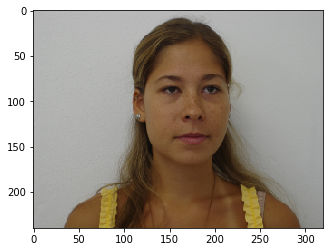

In [176]:
first_image = X_train[1120]
first_image.shape
# first_image = first_image.reshape(28,28,1)
# img = np.array(first_image).reshape(1, 28, 28, 1)
# img.shape
import matplotlib.pyplot as plt
print(f"Shape of original image is {first_image.shape}")
plt.imshow(first_image)
plt.show()

In [177]:
# define a Keras function to accept as input the model image input and return the final dense layer weights and
# convolution layer weights
get_output = K.function([model.layers[0].get_input_at(0), model.layers[0].get_input_at(1)], [vgg_gap_layer.output, model.layers[-1].output])
[conv_outputs, predictions] = get_output([first_image.reshape((1,240,320,3)), first_image.reshape((1,240,320,3))])
conv_outputs = conv_outputs[0,:,:,:]
print(f"Final convolution layer has outputs of {conv_outputs.shape}")
print(f"Final dense layer class weights have output of {class_weights.shape}") 

Final convolution layer has outputs of (7, 10, 512)
Final dense layer class weights have output of (512, 2)


In [178]:
def make_cam(conv_outputs: np.ndarray, class_weights: np.ndarray, original_shape: Tuple[int, int], target_class: int):
    
    '''
    Our class activation map should be the same shape as the first two dimensions of our Conv2D output (24 x 24).
    We finally also need to interpolate our CAM back to the original image (which we do with cv2.resize)
    '''
    
    cam = np.zeros(dtype=np.float32, shape = conv_outputs.shape[0:2])

    # we select ONLY the weight vectors from our class weight matrix (of size 32 x 10) that apply to the target class
    # that we care about (in this case, 2)
    for i, w in enumerate(class_weights[:, target_class]):
        cam += w * conv_outputs[:,:,i]
    cam /= np.max(cam)
    print(f"CAM is shape {cam.shape}")
    return cv2.resize(cam, original_shape)

In [179]:
def make_heatmap(cam: np.ndarray)-> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam < 0.3)] = 0
    print(f"Heatmap is shape {heatmap.shape}")
    return heatmap

In [180]:
cam = make_cam(conv_outputs, class_weights, original_shape=(320,240), target_class=1)
heatmap = make_heatmap(cam)

CAM is shape (7, 10)
Heatmap is shape (240, 320, 3)


Shape of original image is (240, 320, 3)


W0903 04:37:37.941400 140180424148736 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0903 04:37:37.952237 140180424148736 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Final convolution layer has outputs of (7, 10, 512)
Final dense layer class weights have output of (512, 2)
Predicted Male
CAM is shape (7, 10)
Heatmap is shape (240, 320, 3)
CAM is shape (7, 10)
Heatmap is shape (240, 320, 3)


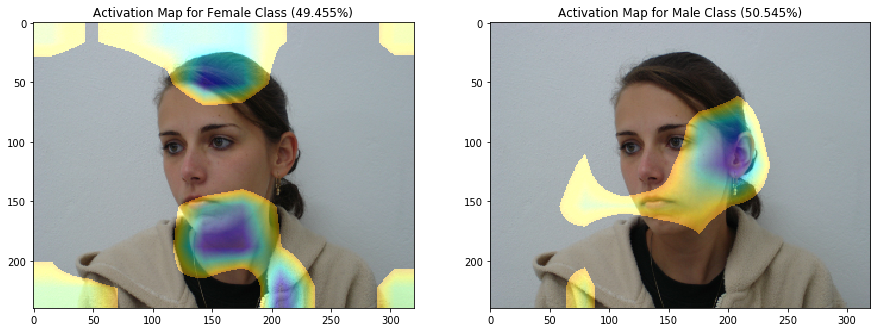

KeyboardInterrupt: 

In [240]:
for i in range(0,X_test.shape[0]):
    first_image = X_test[i]
    
    if i != 505:
        continue
    
    # first_image = first_image.reshape(28,28,1)
    # img = np.array(first_image).reshape(1, 28, 28, 1)
    # img.shape
    import matplotlib.pyplot as plt
    print(f"Shape of original image is {first_image.shape}")

    # define a Keras function to accept as input the model image input and return the final dense layer weights and
    # convolution layer weights
    get_output = K.function([model.layers[0].get_input_at(0), model.layers[0].get_input_at(1)], [vgg_gap_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([first_image.reshape((1,240,320,3)), first_image.reshape((1,240,320,3))])
    conv_outputs = conv_outputs[0,:,:,:]
    print(f"Final convolution layer has outputs of {conv_outputs.shape}")
    print(f"Final dense layer class weights have output of {class_weights.shape}") 

    prediction = model.predict_proba(first_image.reshape((1,240,320,3)))
    predicted_gender = "Male" if prediction.argmax() == 0 else "Female"
    probability = round(prediction[0, prediction.argmax()] * 100, 3)
    print(f"Predicted {predicted_gender}")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
    cam = make_cam(conv_outputs, class_weights, original_shape=(320,240), target_class=1)
    heatmap = make_heatmap(cam)

    new_img = heatmap*0.4 + first_image
    female_final_img = new_img
    axes[0].imshow(np.array(female_final_img,np.int32))
    axes[0].set_title(f"Activation Map for Female Class ({probability if  predicted_gender == 'Female' else round(100 - probability,3)}%)")

    cam = make_cam(conv_outputs, class_weights, original_shape=(320,240), target_class=0)
    heatmap = make_heatmap(cam)
    new_img = heatmap*0.4 + first_image
    male_final_img = new_img
    axes[1].imshow(np.array(male_final_img,np.int32))
    axes[1].set_title(f"Activation Map for Male Class ({probability if predicted_gender == 'Male' else round(100 - probability,3)}%)")
    plt.show()
    input()

In [235]:
import pandas as pd
results = []
guesses = []
for i in range(X_test.shape[0]):
    first_image = X_test[i]
    prediction = model.predict_proba(first_image.reshape((1,240,320,3)))
    predicted_gender = "Male" if prediction.argmax() == 0 else "Female"
    probability = round(prediction[0, prediction.argmax()] * 100, 3)
    results.append(probability)
    guesses.append(predicted_gender)

In [236]:
results = pd.DataFrame(results, columns=["probability"])
results["gender"] = guesses
results["index"] = list(range(X_test.shape[0]))

In [239]:
results[results["probability"] < 60]

,probability,gender,index
338,52.944,Female,338
505,50.545,Male,505
677,57.550,Female,677


In [238]:
results

,probability,gender,index
0,99.999,Male,0
1,99.999,Male,1
2,100.000,Male,2
3,99.998,Male,3
4,99.211,Female,4
5,66.778,Female,5
6,99.992,Female,6
7,99.997,Male,7
8,99.983,Female,8
9,99.959,Male,9
